## Import required libraries

In [58]:
import csv
from pathlib import Path
from sys import __stdout__
from ast import literal_eval
import pickle

from configparser import ConfigParser

import numpy as np
import pandas as pd
import sklearn as sk
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, MultiTaskLasso
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from typing import Dict, Set, Tuple, List, Any, Optional, Callable
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, VarianceThreshold
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline as skPipeline
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin

import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils # type: ignore
mp_drawing_styles = mp.solutions.drawing_styles # type: ignore
mp_face_mesh = mp.solutions.face_mesh # type: ignore
mp_face_mesh_connections = mp.solutions.face_mesh_connections # type: ignore

from settings import *
from auxiliary import plot_selected_features

## Prepare the Training Data

See [./landmarkgenerator.py](./landmarkgenerator.py)

## Helper Functions for Debugging

### Plot the selected features

See [./auxiliary.py:plot_selected_features](./auxiliary.py)

## Load Train Dataset

### For Multi-task Regression

For Multi-task Regression use. All the data from the dataset CSV are load into a single dataframe, such that

$ x_{i,j} \in X, i \leq n, j \leq m $ where $X$ is a $n * m$ matrix, is the $j^{th}$ landmark of the $i^{th}$ training data element.

$ y_i \in Y, i \leq n$ where $Y$ is a $n * 1$ matrix, is the list of blendshape of that element.

In [3]:
tmp_df = pd.read_csv(TRAIN_FILE, header=0, delimiter=",", index_col=False)

# Note that each element of the dataframe is a array.
# Such that its shape is (n_samples, 1).
tmp_multitask_Y : DataFrame = tmp_df["weight"].to_frame()
tmp_multitask_Y = tmp_multitask_Y.applymap(literal_eval).applymap(np.array)

# Now we flatten the arrays in the dataframe.
# To make the shape of the dataframe to be (n_samples, n_targets).
# where n_targets is the number of blendshapes we are predicting.
multitask_Y = list()
for val in tmp_multitask_Y.values:
    multitask_Y.append(val[0])
multitask_Y = pd.DataFrame(multitask_Y)

## Assuming 1st column blendshape index and 2nd column is the weight list.
multitask_X : DataFrame = tmp_df.iloc[:, 2:]
multitask_X = multitask_X.applymap(literal_eval).applymap(np.array)

# A np array for tracking the indices of the blendshapes.
blendshape_indices = tmp_df["blendshape_i"].to_numpy()
blendshape_indices = blendshape_indices - 67

del(tmp_df, tmp_multitask_Y)

In [4]:
print(multitask_X.shape)
print(multitask_Y.shape)
print(blendshape_indices.shape)

(19392, 478)
(19392, 48)
(19392,)


### For multi models regression

All the data from the dataset CSV are load into a list of dataframes, such that

$ dataframe_i$ in list is a dataframe for a specific blendshape.

$ x_{i,j} \in X, i \leq n, j \leq m $ where $X$ is a $n * m$ matrix, is the $j^{th}$ landmark of the $i^{th}$ training data element of this specific blendshape.

$ y_i \in y, i \leq n$ where $y$ is a **vector**, is the weight of that blendshape.

In [5]:
def get_data_for_one_model( X: DataFrame, 
                            Y: DataFrame, 
                            blendshape_idx: int,
                            indices_list) -> Tuple[DataFrame, DataFrame]:
    """Get the trainning data for one blendshape.

    Args:
        X (DataFrame): X for multitask learning
        Y (DataFrame): Y for multitask learning
        blendshape_idx (int): The index of the selected blendshape.
        indices_list: The array tracking the indices of the blendshapes.

    Returns:
        Tuple[DataFrame, DataFrame]: Similar to X for multitask learning, 
                                    but only with the rows for the selected blendshape.
                                    Y is a 1D array of weights for the selected blendshape.
    """
    row_indices = [i for i in range(len(indices_list)) if indices_list[i] == blendshape_idx]
    X = X.iloc[row_indices, :]
    Y = Y.iloc[row_indices, :]
    return (X, Y)


In [6]:
subset_X, subset_Y = get_data_for_one_model(multitask_X, multitask_Y, 0, blendshape_indices)
print(subset_X.shape, subset_Y.shape)

(404, 478) (404, 48)


## Data Processing

At this step, we want to process those data that not-suitable for the multi-task regression.

In [2]:
config_reader = ConfigParser()
config_reader.read('blendshapes.ini')
blendshape_configs = config_reader['blendshapes']

# Those blendshapes are in used.
# Store the index of those blendshapes.
in_used_blendshape_indices = list()
for idx, key in enumerate(blendshape_configs):
    if blendshape_configs.getboolean(key):
        in_used_blendshape_indices.append(idx)

# Figure out the corresponding rows in the multitask_X.
# We know that for each blendshape,
# there n_training_samples and n_avatar in total.
n_training_samples = 101
n_avatar = 4
in_used_multitask_X_row = list()
for i in range(0, n_avatar):
    this_avatar_first_row = n_training_samples * N_BLENDSHAPE * i
    for idx in in_used_blendshape_indices:
        for j in range(0, n_training_samples):
            this_blendshape_first_row = this_avatar_first_row + idx * n_training_samples
            in_used_multitask_X_row.append(this_blendshape_first_row + j)

clear_multitask_X = multitask_X.iloc[in_used_multitask_X_row]
clear_multitask_Y = multitask_Y.iloc[in_used_multitask_X_row]

NameError: name 'multitask_X' is not defined

In [14]:
print("Indices in used:", in_used_blendshape_indices)
print("Rows in used:", in_used_multitask_X_row)
print("Number of used rows:", len(in_used_multitask_X_row))
print("shape of clear_multitask_X:", clear_multitask_X.shape)
print("shape of clear_multitask_Y:", clear_multitask_Y.shape)

Indices in used: [0, 1, 3, 4, 16, 17, 22, 32, 44, 45, 46, 47]
Rows in used: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 303, 304, 305, 306, 307

In [ ]:
# Store the data in case crash, for saving time.
%store clear_multitask_X
%store clear_multitask_Y
%store blendshape_indices

In [3]:
# Refresh all the stored data
%store -r

## Transforming Dataset

### Full Distance

The training set base on distances that includes all the points, labelled by their index in MediaPipe.

In [7]:
class FullDistance(BaseEstimator, TransformerMixin):

    def __init__(self):
        super().__init__()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """Produce the training set with distance between center and all the landmarks

        Args:
            input_df (DataFrame): the origin dataframe from csv file

        Returns:
            DataFrame: the training set with distance between landmarks
        """

        NOSE_IDX = 4
        TOP_DOWN_FACE = (10,152)

        # define the column names
        new_columns = list()
        for idx, _ in enumerate(X.columns):
            new_columns.append(f"distance_{idx}")

        distance_X = DataFrame(columns=new_columns, dtype=np.float64)

        for i, row in X.iterrows():
            new_row = list()
            middle_point = row[NOSE_IDX][:]
            middle_point[1] = (row[TOP_DOWN_FACE[0]][1] + row[TOP_DOWN_FACE[1]][1]) / 2
            middle_point[2] = 0
            max_distance = row[TOP_DOWN_FACE[0]] - row[TOP_DOWN_FACE[1]]
            max_distance[2] = 0
            normalised_distance = np.linalg.norm(max_distance)
            for _, landmark in enumerate(row):
                landmark_copy = landmark[:]
                landmark_copy[2] = 0
                distance = np.linalg.norm(landmark_copy - middle_point)
                new_row.append(distance)
            distance_X.loc[i] = [distance / normalised_distance for distance in new_row] # type: ignore
        return distance_X

### Refine Distance

In [32]:
## This cell shows how the selected_vertex_array in the RefineDistance is produced.

vertices_sets: Dict[str, Set[Tuple[int, int]]] = {
    "FACEMESH_FACE_OVAL": mp_face_mesh_connections.FACEMESH_FACE_OVAL,
    "FACEMESH_LIPS": mp_face_mesh_connections.FACEMESH_LIPS, 
    "FACEMESH_LEFT_EYE": mp_face_mesh_connections.FACEMESH_LEFT_EYE,
    "FACEMESH_LEFT_IRIS": mp_face_mesh_connections.FACEMESH_LEFT_IRIS,
    "FACEMESH_LEFT_EYEBROW": mp_face_mesh_connections.FACEMESH_LEFT_EYEBROW,
    "FACEMESH_RIGHT_EYE": mp_face_mesh_connections.FACEMESH_RIGHT_EYE,
    "FACEMESH_RIGHT_EYEBROW": mp_face_mesh_connections.FACEMESH_RIGHT_EYEBROW,
    "FACEMESH_RIGHT_IRIS": mp_face_mesh_connections.FACEMESH_RIGHT_IRIS}
vertices_set = set()
for value in vertices_sets.values():
    for a, b in value:
        vertices_set.add(a)
        vertices_set.add(b)
selected_vertex_array = sorted(list(vertices_set))
print(selected_vertex_array)
print(len(selected_vertex_array))


[0, 7, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58, 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105, 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191, 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291, 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324, 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380, 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409, 415, 454, 466, 469, 470, 471, 472, 474, 475, 476, 477]
136


In [33]:
class RefineDistance(BaseEstimator, TransformerMixin):

    def __init__(self):
        super().__init__()
        self.selected_vertex_array = [0, 7, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58, 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105, 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191, 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291, 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324, 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380, 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409, 415, 454, 466, 469, 470, 471, 472, 474, 475, 476, 477]

    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """Produce the training set with distance between center and a subset of all landmarks

        Args:
            input_df (DataFrame): the origin dataframe from csv file

        Returns:
            DataFrame: the training set with distance between landmarks
        """

        NOSE_IDX = 4
        TOP_DOWN_FACE = (10,152)

        # define the column names
        new_columns = list()
        for idx, _ in enumerate(self.selected_vertex_array):
            new_columns.append(f"distance_{idx}")

        distance_X = DataFrame(columns=new_columns, dtype=np.float64)

        for i, row in X.iterrows():
            new_row = list()
            middle_point = row[NOSE_IDX][:]
            middle_point[1] = (row[TOP_DOWN_FACE[0]][1] + row[TOP_DOWN_FACE[1]][1]) / 2
            middle_point[2] = 0
            max_distance = row[TOP_DOWN_FACE[0]] - row[TOP_DOWN_FACE[1]]
            max_distance[2] = 0
            normalised_distance = np.linalg.norm(max_distance)
            for idx in self.selected_vertex_array:
                landmark = row[idx]
                landmark_copy = landmark[:]
                landmark_copy[2] = 0
                distance = np.linalg.norm(landmark_copy - middle_point)
                new_row.append(distance)
            distance_X.loc[i] = [distance / normalised_distance for distance in new_row] # type: ignore
        return distance_X

## Features selection

### PCA

In [ ]:
pca = PCA(n_components=5)

### Selected K Best base on Chi2

In [ ]:
selection_k_best_chi2 = SelectKBest(chi2, k=5)

### VarianceThreshold

a customized version of VarianceThreshold

In [ ]:
class CustomVarianceThreshold(VarianceThreshold):

    def __init__(self, threshold=0.0, step=1.0e-7, max_iteration=1000):
        super().__init__(threshold=threshold)
        self.try_count = 0
        self.step = step
        self.max_iteration = max_iteration
    
    def fit_transform(self, X, y = None, **fit_params):
        try:
            return super().fit_transform(X, y, **fit_params)
        except ValueError:
            while True:
                self.threshold -= self.threshold
                if self.try_count > self.max_iteration:
                    self.threshold=0
                    print("No suitable threshold, new threshold = 0")
                    return super().fit_transform(X, y, **fit_params)
                self.max_iteration += 1
                try:
                    return super().fit_transform(X, y, **fit_params)
                except ValueError:
                    continue

## Training

### Define the pipelines

In [ ]:
pipelines: Dict[str, Pipeline] = dict()

# pipelines["default_random_forest_regressor"] = Pipeline(
#     pipeline_name="default_random_forest_regressor",
#     dataset_transformer=training_set_transformers["default"],
#     selection_method=None,
#     model=models["random_forest_regressor"],
#     split=default_split)
# pipelines["distance_random_forest_regressor"] = Pipeline(
#     pipeline_name="distance_random_forest_regressor",
#     dataset_transformer=training_set_transformers["distance"],
#     selection_method=None,
#     model=models["random_forest_regressor"],
#     split=default_split)
# pipelines["default_ada_boost_regressor"] = Pipeline(
#     pipeline_name="default_ada_boost_regressor",
#     dataset_transformer=training_set_transformers["default"],
#     selection_method=None,
#     model=models["ada_boost_regressor"],
#     split=default_split)
# pipelines["distance_ada_boost_regressor"] = Pipeline(
#     pipeline_name="distance_ada_boost_regressor",
#     dataset_transformer=training_set_transformers["distance"],
#     selection_method=None,
#     model=models["ada_boost_regressor"],
#     split=default_split)
# pipelines["default_pca_ada_boost_regressor"] = Pipeline(
#     pipeline_name="default_pca_ada_boost_regressor",
#     dataset_transformer=training_set_transformers["default"],
#     selection_method=selection_methods["PCA"],
#     model=models["ada_boost_regressor"],
#     split=default_split)
# pipelines["distance_pca_ada_boost_regressor"] = Pipeline(
#     pipeline_name="distance_pca_ada_boost_regressor",
#     dataset_transformer=training_set_transformers["distance"],
#     selection_method=selection_methods["PCA"],
#     model=models["ada_boost_regressor"],
#     split=default_split)

## Chi2 only allow non-negative values,
## therefore, the default set is not applicable

# pipelines["distance_chi2_linear_regressor"] = Pipeline(
#     pipeline_name="distance_chi2_linear_regressor",
#     dataset_transformer=training_set_transformers["distance"],
#     selection_method=selection_methods["chi2"],
#     model=models["linear-regression"],
#     split=default_split)
# pipelines["distance_chi2_random_forest_regressor"] = Pipeline(
#     pipeline_name="distance_chi2_random_forest_regressor",
#     dataset_transformer=training_set_transformers["distance"],
#     selection_method=selection_methods["chi2"],
#     model=models["random_forest_regressor"],
#     split=default_split)
# pipelines["distance_chi2_ada_boost_regressor"] = Pipeline(
#     pipeline_name="distance_chi2_ada_boost_regressor",
#     dataset_transformer=training_set_transformers["distance"],
#     selection_method=selection_methods["chi2"],
#     model=models["ada_boost_regressor"],
#     split=default_split)
pipelines["full_distance_chi2_linear_regressor"] = Pipeline(
    pipeline_name="full_distance_chi2_linear_regressor",
    dataset_transformer=training_set_transformers["full_distance"],
    selection_method=selection_methods["chi2"],
    model=models["linear-regression"],
    split=default_split)
pipelines["full_distance_chi2_random_forest_regressor"] = Pipeline(
    pipeline_name="full_distance_chi2_random_forest_regressor",
    dataset_transformer=training_set_transformers["full_distance"],
    selection_method=selection_methods["chi2"],
    model=models["random_forest_regressor"],
    split=default_split)
pipelines["full_distance_chi2_ada_boost_regressor"] = Pipeline(
    pipeline_name="full_distance_chi2_ada_boost_regressor",
    dataset_transformer=training_set_transformers["full_distance"],
    selection_method=selection_methods["chi2"],
    model=models["ada_boost_regressor"],
    split=default_split)
# pipelines["distance_tsne_ada_boost_regressor"] = Pipeline(
#     pipeline_name="distance_tsne_ada_boost_regressor",
#     dataset_transformer=training_set_transformers["distance"],
#     selection_method=selection_methods["TSNE"],
#     model=models["ada_boost_regressor"],
#     split=default_split)
# pipelines["distance_tsne_ada_boost_regressor"] = Pipeline(
#     pipeline_name="distance_tsne_ada_boost_regressor",
#     dataset_transformer=training_set_transformers["distance"],
#     selection_method=selection_methods["TSNE"],
#     model=models["ada_boost_regressor"],
#     split=default_split)

In [ ]:
result_pipelines = dict()

In [ ]:
print(len(blendshape_training_set_lst))

NameError: name 'blendshape_training_set_lst' is not defined

In [129]:


weight = 100
searches = []
fulldistance_chi2_gridsearch_linear_regressor = skPipeline(steps=[('data_transform', FullDistance()), ('feature_selection', SelectKBest(chi2)), ('regression', LinearRegression())])
# param_grid =  {
#     'data_transform__k': [k for k in range(1,10)]
# }

fulldistance_infogain_gridsearch_linear_regressor = skPipeline(steps=[('data_transform', FullDistance()), ('feature_selection', SelectKBest(mutual_info_regression)), ('regression', LinearRegression())])
# param_grid =  {
#     'data_transform__k': [k for k in range(1,10)]
# }

fulldistance_varthershold_gridsearch_linear_regressor = skPipeline(steps=[('data_transform', FullDistance()), ('feature_selection', CustomVarianceThreshold()), ('regression', LinearRegression())])

fulldistance_varthershold_gridsearch_svr = skPipeline(steps=[('data_transform', FullDistance()), ('feature_selection', CustomVarianceThreshold()), ('regression', SVR())])

fulldistance_multilasso = skPipeline(steps=[('data_transform', FullDistance()), ('regression', MultiTaskLasso(alpha=0.25))])

def custom_score_func(pipeline, X, y):

    feature_selector = pipeline.named_steps['chi2']
    _landmarks = feature_selector.get_support(indices=True)
    

# searches.append(GridSearchCV(
#                 estimator=fulldistance_chi2_gridsearch_linear_regressor, 
#                 param_grid={
#                     'feature_selection__k': [k for k in range(1,10)]
#                 }, 
#                 return_train_score=True, 
#                 error_score='raise'))
# searches.append(GridSearchCV(
#                 estimator=fulldistance_infogain_gridsearch_linear_regressor, 
#                 param_grid={
#                     'feature_selection__k': [k for k in range(1,10)]
#                 }, 
#                 return_train_score=True, 
#                 error_score='raise'))
# searches.append(GridSearchCV(
#                 estimator=fulldistance_varthershold_gridsearch_linear_regressor,
#                 param_grid={
#                     'feature_selection__threshold': [2.5e-5]
#                 }, 
#                 return_train_score=True, 
#                 error_score='raise',
#                 verbose=3,
#                 cv=2)
#                 )
# searches.append(GridSearchCV(
# estimator=fulldistance_multilasso,
# param_grid={
#     'regression__alpha': [1.0, 1.5]
# }, 
# return_train_score=True, 
# error_score='raise',
# verbose=3,
# cv=2)
# )
# searches[0].fit(clear_multitask_X, clear_multitask_Y)
print(clear_multitask_X.shape, clear_multitask_Y.shape)
fulldistance_multilasso.fit(clear_multitask_X, clear_multitask_Y)
# searches.append(GridSearchCV(
#                 estimator=fulldistance_varthershold_gridsearch_svr,
#                 param_grid=[{
#                     'feature_selection__threshold': [2.5e-5],
#                     'regression__C': [0.75, 1, 1,5],
#                     'regression__kernel': ['linear'],
#                     'regression__epsilon': [0.5, 1, 2],
#                 },
#                 {
#                     'feature_selection__threshold': [2.5e-5],
#                     'regression__C': [0.75, 1, 1,5],
#                     'regression__kernel': ['rbf'],
#                     'regression__epsilon': [0.5, 1, 2],
#                     'regression__gamma': ['auto', 'scale'],
#                 }], 
#                 return_train_score=True, 
#                 error_score='raise',
#                 verbose=3,
#                 cv=2)
#                 )

# def train_on_each_blendshape():
#     for search in searches:
#         tmp_res = []
#         for training_set in blendshape_training_set_lst[:]: 
#             print(training_set.blendshape_idx)
#             print(training_set.blendshape_name.to_list()[0])
#             search.fit(training_set.X, training_set.Y)
#             print("Best Estimator:", search.best_estimator_)
#             print("Best Train Score:", search.best_score_)
#             tmp_res.append(search.best_estimator_)
#             best_filter = search.best_estimator_.named_steps["feature_selection"]
#             best_landmarks = best_filter.get_support(indices=True)
#             filename_idx = training_set.blendshape_idx
#             filename_data_transform = search.best_estimator_.named_steps['data_transform'].__class__.__name__
#             filename_feature_selection = search.best_estimator_.named_steps['feature_selection'].__class__.__name__
#             if search.best_estimator_.named_steps['feature_selection'].__class__ == SelectKBest:
#                 filename_feature_selection += f"{search.best_estimator_.named_steps['feature_selection'].score_func.__name__}"
#             filename_regression_model = search.best_estimator_.named_steps['regression'].__class__.__name__
#             plot_selected_features(f"./index{training_set.blendshape_idx}-weight${weight}.png", best_landmarks, f"{filename_idx}_{filename_data_transform}_{filename_feature_selection}_{filename_regression_model}")
#         result_pipelines[f"{filename_data_transform}_{filename_feature_selection}_{filename_regression_model}"] = tmp_res

# def train_on_all_data():

#     def transform_y(y, idx: int):
#         target = y
#         target = [0 for blendshape in blendshape_training_set_lst[:idx] for j in range(blendshape.Y.shape[0])]\
#                 + target\
#                 + [0 for blendshape in blendshape_training_set_lst[min(len(blendshape_training_set_lst), idx+1):] for j in range(blendshape.Y.shape[0])]
#         return target

#     for search in searches:
#         tmp_res = []
#         for idx, training_set in enumerate(blendshape_training_set_lst[:]): 
#             print(training_set.blendshape_idx)
#             print(training_set.blendshape_name.to_list()[0])
#             search.fit(all_X, transform_y(training_set.Y.to_list(), idx))
#             print("Best Estimator:", search.best_estimator_)
#             print("Best Train Score:", search.best_score_)
#             tmp_res.append(search.best_estimator_)
#             best_filter = search.best_estimator_.named_steps["feature_selection"]
#             best_landmarks = best_filter.get_support(indices=True)
#             filename_idx = training_set.blendshape_idx
#             filename_data_transform = search.best_estimator_.named_steps['data_transform'].__class__.__name__
#             filename_feature_selection = search.best_estimator_.named_steps['feature_selection'].__class__.__name__
#             if search.best_estimator_.named_steps['feature_selection'].__class__ == SelectKBest:
#                 filename_feature_selection += f"{search.best_estimator_.named_steps['feature_selection'].score_func.__name__}"
#             filename_regression_model = search.best_estimator_.named_steps['regression'].__class__.__name__
#             # plot_selected_features(f"./index{training_set.blendshape_idx}-weight${weight}.png", best_landmarks, f"{filename_idx}_{filename_data_transform}_{filename_feature_selection}_{filename_regression_model}")
#         result_pipelines[f"all_{filename_data_transform}_{filename_feature_selection}_{filename_regression_model}"] = tmp_res

# train_on_each_blendshape()
# train_on_all_data()

(3636, 478) (3636, 48)


Pipeline(steps=[('data_transform', FullDistance()),
                ('regression', MultiTaskLasso(alpha=0.25))])

## Training Multi-task Model

### Multilasso

In [46]:
fulldistance_multilasso = skPipeline(steps=[('data_transform', FullDistance()), ('regression', MultiTaskLasso())])
fulldistance_multilasso_search = GridSearchCV(estimator=fulldistance_multilasso,
             param_grid={'regression__alpha' : [0.5, 1.0, 1.5],
                        },
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
             refit='neg_mean_squared_error',
             cv=5,
             verbose=3)
fulldistance_multilasso_search.fit(clear_multitask_X, clear_multitask_Y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END regression__alpha=0.5; neg_mean_absolute_error: (test=-1.903) neg_mean_squared_error: (test=-63.448) r2: (test=0.747) total time=  45.6s
[CV 2/5] END regression__alpha=0.5; neg_mean_absolute_error: (test=-1.929) neg_mean_squared_error: (test=-67.247) r2: (test=0.574) total time=  41.5s
[CV 3/5] END regression__alpha=0.5; neg_mean_absolute_error: (test=-1.924) neg_mean_squared_error: (test=-65.388) r2: (test=0.749) total time=  42.1s
[CV 4/5] END regression__alpha=0.5; neg_mean_absolute_error: (test=-1.915) neg_mean_squared_error: (test=-65.596) r2: (test=0.732) total time=  44.9s
[CV 5/5] END regression__alpha=0.5; neg_mean_absolute_error: (test=-1.944) neg_mean_squared_error: (test=-68.230) r2: (test=0.749) total time=  41.5s
[CV 1/5] END regression__alpha=1.0; neg_mean_absolute_error: (test=-1.903) neg_mean_squared_error: (test=-63.448) r2: (test=0.747) total time=  42.2s
[CV 2/5] END regression__alpha=1.0; neg_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_transform', FullDistance()),
                                       ('regression', MultiTaskLasso())]),
             param_grid={'regression__alpha': [0.5, 1.0, 1.5]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error',
                      'r2'],
             verbose=3)

In [47]:
for item in fulldistance_multilasso_search.cv_results_.items():
    print(item)
fulldistance_multilasso_search.best_estimator_

('mean_fit_time', array([38.04458838, 38.41220503, 37.28625612]))
('std_fit_time', array([1.60162758, 1.27323016, 0.36441486]))
('mean_score_time', array([5.06848125, 4.98422523, 5.0977015 ]))
('std_score_time', array([0.2938699 , 0.20442274, 0.39584178]))
('param_regression__alpha', masked_array(data=[0.5, 1.0, 1.5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object))
('params', [{'regression__alpha': 0.5}, {'regression__alpha': 1.0}, {'regression__alpha': 1.5}])
('split0_test_neg_mean_absolute_error', array([-1.90304123, -1.90304123, -1.90304123]))
('split1_test_neg_mean_absolute_error', array([-1.9291454, -1.9291454, -1.9291454]))
('split2_test_neg_mean_absolute_error', array([-1.92359542, -1.92359542, -1.92359542]))
('split3_test_neg_mean_absolute_error', array([-1.91506999, -1.91506999, -1.91506999]))
('split4_test_neg_mean_absolute_error', array([-1.94361531, -1.94361531, -1.94361531]))
('mean_test_neg_mean_absolute_error', array([-1.9228934

Pipeline(steps=[('data_transform', FullDistance()),
                ('regression', MultiTaskLasso(alpha=0.5))])

In [48]:
# with open('tmp/fulldistance_multilasso_search.pkl', 'wb') as file:
#     pickle.dump(fulldistance_multilasso_search, file)

In [ ]:
with open('tmp/fulldistance_multilasso_search.pkl', 'rb') as file:
    fulldistance_multilasso_search = pickle.load(fulldistance_multilasso_search, file)

### Decision Tree Multi-task Regression

In [53]:
fulldistance_dtregression = skPipeline(steps=[('data_transform', FullDistance()), ('regression', DecisionTreeRegressor())])
fulldistance_dtregression.fit(clear_multitask_X, clear_multitask_Y)
fulldistance_dtregression_search = GridSearchCV(estimator=fulldistance_dtregression,
             param_grid={'regression__min_samples_split' : [5, 10, 20],
                        },
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
             refit='neg_mean_squared_error',
             cv=5,
             verbose=3)
fulldistance_dtregression_search.fit(clear_multitask_X, clear_multitask_Y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END regression__min_samples_split=5; neg_mean_absolute_error: (test=-1.242) neg_mean_squared_error: (test=-72.505) r2: (test=0.731) total time=  50.1s
[CV 2/5] END regression__min_samples_split=5; neg_mean_absolute_error: (test=-1.041) neg_mean_squared_error: (test=-58.063) r2: (test=0.790) total time=  47.5s
[CV 3/5] END regression__min_samples_split=5; neg_mean_absolute_error: (test=-0.763) neg_mean_squared_error: (test=-32.655) r2: (test=0.846) total time=  49.4s
[CV 4/5] END regression__min_samples_split=5; neg_mean_absolute_error: (test=-1.056) neg_mean_squared_error: (test=-54.168) r2: (test=0.764) total time=  49.2s
[CV 5/5] END regression__min_samples_split=5; neg_mean_absolute_error: (test=-0.920) neg_mean_squared_error: (test=-45.451) r2: (test=0.834) total time=  51.1s
[CV 1/5] END regression__min_samples_split=10; neg_mean_absolute_error: (test=-1.268) neg_mean_squared_error: (test=-71.972) r2: (test=0.765

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_transform', FullDistance()),
                                       ('regression',
                                        DecisionTreeRegressor())]),
             param_grid={'regression__min_samples_split': [5, 10, 20]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error',
                      'r2'],
             verbose=3)

In [54]:
for item in fulldistance_dtregression_search.cv_results_.items():
    print(item)

('mean_fit_time', array([44.59508486, 43.44808993, 43.42432418]))
('std_fit_time', array([1.04297118, 0.27365341, 1.43481575]))
('mean_score_time', array([4.86611576, 4.64838457, 4.91661572]))
('std_score_time', array([0.19877748, 0.08647005, 0.34487819]))
('param_regression__min_samples_split', masked_array(data=[5, 10, 20],
             mask=[False, False, False],
       fill_value='?',
            dtype=object))
('params', [{'regression__min_samples_split': 5}, {'regression__min_samples_split': 10}, {'regression__min_samples_split': 20}])
('split0_test_neg_mean_absolute_error', array([-1.24237722, -1.26819898, -1.24745637]))
('split1_test_neg_mean_absolute_error', array([-1.04125859, -1.06781907, -1.08133977]))
('split2_test_neg_mean_absolute_error', array([-0.76343607, -0.82120678, -0.76090612]))
('split3_test_neg_mean_absolute_error', array([-1.05593539, -1.08748273, -1.08141693]))
('split4_test_neg_mean_absolute_error', array([-0.91962648, -0.93788898, -0.91742504]))
('mean_test_

In [57]:
# with open('tmp/fulldistance_dtregression_search.pkl', 'wb') as file:
#     pickle.dump(fulldistance_dtregression_search, file)

In [ ]:
with open('tmp/fulldistance_dtregression_search.pkl', 'rb') as file:
    fulldistance_dtregression_search = pickle.load(fulldistance_dtregression_search, file)

### KNN 

In [9]:
fulldistance_knnregression = skPipeline(steps=[('data_transform', FullDistance()), ('regression', RadiusNeighborsRegressor(weights='distance'))])
fulldistance_knnregression.fit(clear_multitask_X, clear_multitask_Y)
fulldistance_knnregression_search = GridSearchCV(estimator=fulldistance_knnregression,
             param_grid={'regression__radius' : [0.5, 1.0, 1.5]},
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
             refit='neg_mean_squared_error',
             cv=5,
             verbose=3)
fulldistance_knnregression_search.fit(clear_multitask_X, clear_multitask_Y)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END regression__radius=0.5; neg_mean_absolute_error: (test=-1.772) neg_mean_squared_error: (test=-59.211) r2: (test=0.763) total time=  43.0s
[CV 2/5] END regression__radius=0.5; neg_mean_absolute_error: (test=-1.870) neg_mean_squared_error: (test=-67.555) r2: (test=0.737) total time=  43.9s
[CV 3/5] END regression__radius=0.5; neg_mean_absolute_error: (test=-1.826) neg_mean_squared_error: (test=-62.901) r2: (test=0.758) total time=  43.1s
[CV 4/5] END regression__radius=0.5; neg_mean_absolute_error: (test=-1.806) neg_mean_squared_error: (test=-62.770) r2: (test=0.740) total time=  42.2s
[CV 5/5] END regression__radius=0.5; neg_mean_absolute_error: (test=-1.809) neg_mean_squared_error: (test=-63.849) r2: (test=0.763) total time=  43.2s
[CV 1/5] END regression__radius=1.0; neg_mean_absolute_error: (test=-1.876) neg_mean_squared_error: (test=-63.992) r2: (test=0.748) total time=  43.6s
[CV 2/5] END regression__radius=1.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_transform', FullDistance()),
                                       ('regression',
                                        RadiusNeighborsRegressor(weights='distance'))]),
             param_grid={'regression__radius': [0.5, 1.0, 1.5]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error',
                      'r2'],
             verbose=3)

In [35]:
refinedistance_knnregression = skPipeline(steps=[('data_transform', RefineDistance()), ('regression', RadiusNeighborsRegressor(weights='distance'))])
refinedistance_knnregression.fit(clear_multitask_X, clear_multitask_Y)
refinedistance_knnregression_search = GridSearchCV(estimator=refinedistance_knnregression,
             param_grid={'regression__radius' : [0.5, 1.0, 1.5]},
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
             refit='neg_mean_squared_error',
             cv=5,
             verbose=3)
refinedistance_knnregression_search.fit(clear_multitask_X, clear_multitask_Y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END regression__radius=0.5; neg_mean_absolute_error: (test=-1.852) neg_mean_squared_error: (test=-63.013) r2: (test=0.750) total time=  16.0s
[CV 2/5] END regression__radius=0.5; neg_mean_absolute_error: (test=-1.861) neg_mean_squared_error: (test=-66.755) r2: (test=0.716) total time=  14.8s
[CV 3/5] END regression__radius=0.5; neg_mean_absolute_error: (test=-1.839) neg_mean_squared_error: (test=-63.535) r2: (test=0.756) total time=  14.9s
[CV 4/5] END regression__radius=0.5; neg_mean_absolute_error: (test=-1.829) neg_mean_squared_error: (test=-63.950) r2: (test=0.737) total time=  14.9s
[CV 5/5] END regression__radius=0.5; neg_mean_absolute_error: (test=-1.845) neg_mean_squared_error: (test=-65.979) r2: (test=0.756) total time=  15.6s
[CV 1/5] END regression__radius=1.0; neg_mean_absolute_error: (test=-1.852) neg_mean_squared_error: (test=-63.013) r2: (test=0.750) total time=  16.1s
[CV 2/5] END regression__radius=1.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_transform', RefineDistance()),
                                       ('regression',
                                        RadiusNeighborsRegressor(weights='distance'))]),
             param_grid={'regression__radius': [0.5, 1.0, 1.5]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error',
                      'r2'],
             verbose=3)

In [39]:
for item in fulldistance_knnregression_search.cv_results_.items():
    print(item)
print()
for item in refinedistance_knnregression_search.cv_results_.items():
    print(item)

('mean_fit_time', array([37.39331732, 38.95653033, 37.41706538]))
('std_fit_time', array([0.48200297, 3.16573716, 1.02934685]))
('mean_score_time', array([5.71015687, 6.15854869, 5.72989058]))
('std_score_time', array([0.19524995, 0.54239105, 0.24427609]))
('param_regression__radius', masked_array(data=[0.5, 1.0, 1.5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object))
('params', [{'regression__radius': 0.5}, {'regression__radius': 1.0}, {'regression__radius': 1.5}])
('split0_test_neg_mean_absolute_error', array([-1.77207668, -1.87566428, -1.87566428]))
('split1_test_neg_mean_absolute_error', array([-1.87007055, -1.87824007, -1.87824007]))
('split2_test_neg_mean_absolute_error', array([-1.82604356, -1.84962363, -1.84962363]))
('split3_test_neg_mean_absolute_error', array([-1.80599671, -1.83363241, -1.83363241]))
('split4_test_neg_mean_absolute_error', array([-1.80923432, -1.8575494 , -1.8575494 ]))
('mean_test_neg_mean_absolute_error', array([-1.

In [36]:
# with open('tmp/fulldistance_knnregression_search.pkl', 'wb') as file:
#     pickle.dump(fulldistance_knnregression_search, file)
# with open('tmp/refinedistance_knnregression_search.pkl', 'wb') as file:
#     pickle.dump(refinedistance_knnregression_search, file)

In [ ]:
with open('tmp/fulldistance_knnregression_search.pkl', 'rb') as file:
    fulldistance_knnregression_search = pickle.load(file)
with open('tmp/refinedistance_knnregression_search.pkl', 'rb') as file:
    refinedistance_knnregression_search = pickle.load(file)

In [20]:
idx_to_plot = 68
BEGIN_IDX = 67
END_IDX = 114 - BEGIN_IDX
idx_to_plot -= BEGIN_IDX
SELECTED_PIPELINE = "FullDistance_CustomVarianceThreshold_LinearRegression"

transformed_X = result_pipelines[SELECTED_PIPELINE][idx_to_plot].named_steps['data_transform'].transform(all_X)
transformed_X = result_pipelines[SELECTED_PIPELINE][idx_to_plot].named_steps['feature_selection'].transform(transformed_X)
target = blendshape_training_set_lst[idx_to_plot].Y.to_list()
new_df = pd.DataFrame(transformed_X, columns=[f"feature_{i}" for i in range(len(transformed_X[0]))])
target = [0 for blendshape in blendshape_training_set_lst[:idx_to_plot] for j in range(blendshape.Y.shape[0])]\
            + target\
            + [0 for blendshape in blendshape_training_set_lst[min(END_IDX, idx_to_plot+1):] for j in range(blendshape.Y.shape[0])]
print(new_df)
new_df['target'] = target
g1 = sns.PairGrid(new_df, diag_sharey=False)
g1.map_lower(sns.scatterplot, hue=new_df['target'], palette='coolwarm', hue_norm=(0, 1))
g1.map_diag(sns.histplot, kde=True, color='blue')
g1.add_legend()

transformed_X = result_pipelines[SELECTED_PIPELINE][idx_to_plot].named_steps['data_transform'].transform(blendshape_training_set_lst[idx_to_plot].X)
transformed_X = result_pipelines[SELECTED_PIPELINE][idx_to_plot].named_steps['feature_selection'].transform(transformed_X)
new_df = pd.DataFrame(transformed_X, columns=[f"feature_{i}" for i in range(len(transformed_X[0]))])
target = blendshape_training_set_lst[idx_to_plot].Y.to_list()
new_df['target'] = target
g2 = sns.PairGrid(new_df, diag_sharey=False)
g2.map_lower(sns.scatterplot, hue=new_df['target'], palette='coolwarm', hue_norm=(0, 1))
g2.map_diag(sns.histplot, kde=True, color='blue')
g2.add_legend()
plt.show()

NameError: name 'result_pipelines' is not defined

### Call the fit for training

In [ ]:
selectors_groups: Dict[str, Dict[str, Any]] = dict()
predictors_groups: Dict[str, Dict[str, Any]] = dict()

for pipeline in pipelines.values():
    selectors, predictors = pipeline.fit_(training_set_list=blendshape_training_set_lst)
    selectors_groups[pipeline.pipeline_name] = selectors
    predictors_groups[pipeline.pipeline_name] = predictors

## Test on a single static input

In [56]:
def get_selected_point_idx(feature_name: str) -> int:
    return int(feature_name.split("_")[-1])

res = []

IDX = 99
WEIGHT = 100
IMAGE_FILES = [f"/Users/lokeyli/Documents/UCL/year_3/comp0029/TEST-img-leranli.jpg"]

# selectors = selectors_groups["full_distance_chi2_linear_regressor"]
# predictors = predictors_groups["full_distance_chi2_linear_regressor"]

# for idx, selector in selectors.items():
#     selected_features = selector.get_support(indices=True)
#     print(idx)
#     print(selected_features)

# define a function to return a int, in range [min, max],
# input is a float.

def int_in_given_range(x: float, min: int, max: int) -> int:
    if x < min:
        return min
    elif x > max:
        return max
    else:
        return int(x)

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
) as face_mesh:
    for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file)
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Print and draw face mesh landmarks on the image.
        if not results.multi_face_landmarks:
            continue
        annotated_image = image.copy()
        arr = []
        for face_landmarks in results.multi_face_landmarks:
            for a in face_landmarks.landmark:
                arr.append(np.array([a.x, a.y, a.z]))
        predict_df = pd.DataFrame([arr], columns=HEADERS[2:])
        res = fulldistance_knnregression_search.best_estimator_.predict(predict_df)
        print(res)
        # for pipeline in result_pipelines["FullDistance_CustomVarianceThreshold_LinearRegression"]:
        #     weight = pipeline.predict(predict_df)[0]
        #     print(int_in_given_range(weight, 0, 100), end=", ")
        #     res.append(int_in_given_range(weight, 0, 100))
        # print("")
        # mask = [True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, True, True, True, False, True, True, False, True, True, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, True, True, False, True, True, False, False, False, False]
        # for idx, r in enumerate(res):
        #     if not mask[idx]:
        #         res[idx] = 0
        # print(res)
            

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         76.08104325  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]]


In [655]:
# print(blendshape_training_set_lst[IDX-67].blendshape_name)
mask = [True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, True, True, True, False, True, True, False, True, True, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, True, True, False, True, True, False, False, False]
print(len(mask))
print(114 - 67)

46
47


## Export the ideal models

In [18]:
selector_group = selectors_groups["distance_chi2_linear_regressor"]
print("selector_group", selector_group)
for blendshape_i, selector in selector_group.items():
    with open(f"fm2bs_selector_{blendshape_i}.pkl", "wb") as f:
        dump(selector, f)
predictors_group = predictors_groups["distance_chi2_linear_regressor"]
print("predictors_group", predictors_group)
for blendshape_i, model in predictors_group.items():
    with open(f"fm2bs_model_{blendshape_i}.pkl", "wb") as f:
        dump(model, f)

NameError: name 'selectors_groups' is not defined

## Draw different parts on mediapipe

In [103]:
distance_X = FullDistance().transform(clear_multitask_X)

(3636, 478)
(3636, 48)


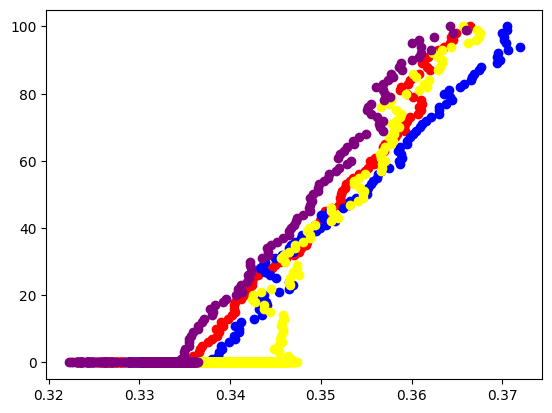

In [128]:
n_blendshape = len(in_used_blendshape_indices) * 101
selected_feature_idx = 300
selected_target_idx = 1

print(distance_X.shape)
print(clear_multitask_Y.shape)

colors = ["red","blue","yellow","purple"]
for i, color in enumerate(colors):
    plt.scatter(distance_X.iloc[i*n_blendshape:(i+1)*n_blendshape, selected_feature_idx], 
                clear_multitask_Y.iloc[i*n_blendshape:(i+1)*n_blendshape, selected_target_idx], c=color)
plt.show()

In [88]:
n_targets = multitask_Y.iloc[0].values[0].shape
n_features = distance_X.shape[1]
fig, axes = plt.subplots(nrows=n_targets, ncols=n_features, figsize=(15, 8))

for i in range(n_targets):
    for j in range(n_features):
        axes[i, j].scatter(X[:, j], Y[:, i], alpha=0.5)
        axes[i, j].set_xlabel(f"Feature {j+1}")
        axes[i, j].set_ylabel(f"Target {i+1}")

fig.tight_layout()
plt.show()

ValueError: Number of rows must be a positive integer, not (48,)

<Figure size 1500x800 with 0 Axes>

In [8]:
IMAGE_FILES = ["../Male_Adult_01_facial-index78-weight0.png"]

drawing_spec = mp_drawing.DrawingSpec(color=[255, 255, 255], thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
) as face_mesh:
    for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file)
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        annotated_image = image.copy()
        # Print and draw face mesh landmarks on the image.
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # 为每个 Landmark 绘制编号和圆圈
                for idx, landmark in enumerate(face_landmarks.landmark):
                    mp_drawing.draw_landmarks(
                        image=annotated_image,
                        landmark_list=face_landmarks,
                        landmark_drawing_spec=drawing_spec,
                    )
                    height, width, _ = annotated_image.shape
                    x, y = int(landmark.x * width), int(landmark.y * height)
                    cv2.putText(annotated_image, str(idx), (x, y), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.imwrite("face-landmark-numbered.png", annotated_image)